
# linear


## loading the data

In [11]:
import open3d as o3d
import numpy as np
from mcap.writer import Writer
import json
import base64
import cv2
import time
import matplotlib.pyplot as plt
from dataclasses import dataclass

print("Toronto-3D MCAP )\n")


Toronto-3D MCAP )



In [2]:
# LOAD DATA

file_path = '/Users/danya/Downloads/Toronto_3D/L001.ply'
pcd = o3d.io.read_point_cloud(file_path)
points = np.asarray(pcd.points)
colors = np.asarray(pcd.colors)

if len(points) > 1000000:
    indices = np.random.choice(len(points), 1000000, replace=False)
    points, colors = points[indices], colors[indices]

original_center = points.mean(axis=0)
points = points - original_center
extent = points.max(axis=0) - points.min(axis=0)
z_min, z_max = points[:, 2].min(), points[:, 2].max()
z_center = (z_min + z_max) / 2

print(f" Loaded {len(points):,} points")
print(f"   Scene extent: [{extent[0]:.0f}, {extent[1]:.0f}, {extent[2]:.0f}]m\n")


 Loaded 1,000,000 points
   Scene extent: [268, 322, 41]m



## camera angle

In [3]:
# CAMERA


@dataclass
class PinholeCamera:
    width: int = 1280
    height: int = 720
    fx: float = 400.0
    fy: float = 400.0
    cx: float = 640.0
    cy: float = 360.0
    
    def render_image(self, points_3d, colors, camera_pose):
        R = camera_pose[:3, :3]
        t = camera_pose[:3, 3]
        points_cam = (points_3d - t) @ R.T
        
        valid = points_cam[:, 2] > 0.1
        if not np.any(valid):
            return np.zeros((self.height, self.width, 3), dtype=np.uint8)
        
        points_cam = points_cam[valid]
        valid_colors = colors[valid]
        
        z = points_cam[:, 2]
        u = (self.fx * points_cam[:, 0] / z + self.cx).astype(np.int32)
        v = (self.fy * points_cam[:, 1] / z + self.cy).astype(np.int32)
        
        in_bounds = (u >= 0) & (u < self.width) & (v >= 0) & (v < self.height)
        if not np.any(in_bounds):
            return np.zeros((self.height, self.width, 3), dtype=np.uint8)
        
        u, v, z = u[in_bounds], v[in_bounds], z[in_bounds]
        valid_colors = valid_colors[in_bounds]
        
        img = np.zeros((self.height, self.width, 3), dtype=np.uint8)
        sort_idx = np.argsort(-z)
        img[v[sort_idx], u[sort_idx]] = (valid_colors[sort_idx] * 255).astype(np.uint8)
        
        return img

camera = PinholeCamera()
print(f" Camera: {camera.width}x{camera.height}")


 Camera: 1280x720


## lidar setup

In [5]:
# LIDAR


class SimpleLiDAR:
    def __init__(self):
        self.num_lasers = 64
        self.horizontal_res = 0.18
        self.max_range = 60.0
        self.vertical_fov = (-25, 15)
    
    def scan(self, points_3d, lidar_pose):
        R = lidar_pose[:3, :3]
        t = lidar_pose[:3, 3]
        points_lidar = (points_3d - t) @ R.T
        
        x, y, z = points_lidar[:, 0], points_lidar[:, 1], points_lidar[:, 2]
        range_dist = np.sqrt(x**2 + y**2 + z**2)
        
        valid = (range_dist > 0.1) & (range_dist < self.max_range)
        if not np.any(valid):
            return np.zeros((0, 3))
        
        x, y, z = x[valid], y[valid], z[valid]
        range_dist = range_dist[valid]
        points_world = points_3d[valid]
        
        azimuth = np.arctan2(y, x)
        elevation = np.arcsin(np.clip(z / range_dist, -1, 1))
        
        min_elev = np.deg2rad(self.vertical_fov[0])
        max_elev = np.deg2rad(self.vertical_fov[1])
        elev_valid = (elevation >= min_elev) & (elevation <= max_elev)
        if not np.any(elev_valid):
            return np.zeros((0, 3))
        
        azimuth, elevation, range_dist = azimuth[elev_valid], elevation[elev_valid], range_dist[elev_valid]
        points_world = points_world[elev_valid]
        
        num_horizontal = int(360 / self.horizontal_res)
        az_bins = ((azimuth + np.pi) / (2*np.pi) * num_horizontal).astype(np.int32)
        el_bins = ((elevation - min_elev) / (max_elev - min_elev) * self.num_lasers).astype(np.int32)
        el_bins = np.clip(el_bins, 0, self.num_lasers - 1)
        bin_idx = el_bins * num_horizontal + az_bins
        
        unique_bins = np.unique(bin_idx)
        scan_points = [points_world[np.where(bin_idx == b)[0][np.argmin(range_dist[bin_idx == b])]] for b in unique_bins]
        
        return np.array(scan_points) if scan_points else np.zeros((0, 3))

lidar = SimpleLiDAR()
print(f" LiDAR: {lidar.max_range}m range\n")


 LiDAR: 60.0m range



## linear trajectory- straight path

In [6]:
# LINEAR TRAJECTORY - STRAIGHT PATH

def create_linear_trajectory(start_point, end_point, height, num_frames, duration=15.0):
    """
    Create a straight-line trajectory from start to end point.
    Camera looks forward along the path (like driving down a street).
    """
    timestamps = np.linspace(0, duration, num_frames)
    poses = []
    
    # Calculate path direction
    path_direction = end_point - start_point
    path_length = np.linalg.norm(path_direction)
    path_direction = path_direction / path_length
    
    for i, t in enumerate(timestamps):
        # Linear interpolation along path
        progress = i / (num_frames - 1)  # 0.0 to 1.0
        
        # Position along the path
        position = start_point + path_direction * path_length * progress
        position[2] = height  # Set height above scene
        
        # Camera looks forward along path (slightly down)
        look_ahead = position + path_direction * 20.0  # Look 20m ahead
        look_ahead[2] = height - 10.0  # Look down slightly
        
        forward = look_ahead - position
        forward = forward / np.linalg.norm(forward)
        
        # Build camera coordinate frame
        world_up = np.array([0, 0, 1])
        right = np.cross(forward, world_up)
        right = right / (np.linalg.norm(right) + 1e-8)
        up = np.cross(right, forward)
        
        pose = np.eye(4)
        pose[:3, :3] = np.column_stack([right, up, forward])
        pose[:3, 3] = position
        poses.append(pose)
    
    return timestamps, poses

# Define linear path through the scene
# Start from one end, fly to the other end
start_point = np.array([-extent[0]/3, -extent[1]/3, 0])
end_point = np.array([extent[0]/3, extent[1]/3, 0])
height_above = z_max + 15.0  # 15m above highest point
num_frames = 150

print(f" Linear Trajectory:")
print(f"   Start: [{start_point[0]:.0f}, {start_point[1]:.0f}]")
print(f"   End: [{end_point[0]:.0f}, {end_point[1]:.0f}]")
print(f"   Height: {height_above:.1f}m above scene")
print(f"   Distance: {np.linalg.norm(end_point - start_point):.0f}m")
print(f"   Frames: {num_frames}\n")

timestamps, poses = create_linear_trajectory(
    start_point=start_point,
    end_point=end_point,
    height=height_above,
    num_frames=num_frames,
    duration=15.0
)

# Test visibility
test_pose = poses[75]
test_R, test_t = test_pose[:3, :3], test_pose[:3, 3]
test_pts_cam = (points - test_t) @ test_R.T
test_valid = test_pts_cam[:, 2] > 0.1
print(f" Visibility check (mid-flight):")
print(f"   Camera at: [{test_t[0]:.0f}, {test_t[1]:.0f}, {test_t[2]:.0f}]")
print(f"   Points visible: {np.sum(test_valid):,} ({np.sum(test_valid)/len(points)*100:.0f}%)\n")


 Linear Trajectory:
   Start: [-89, -107]
   End: [89, 107]
   Height: 43.6m above scene
   Distance: 279m
   Frames: 150

 Visibility check (mid-flight):
   Camera at: [1, 1, 44]
   Points visible: 834,399 (83%)



In [7]:
# RENDER

print(" Rendering linear flythrough...")
camera_images, lidar_scans = [], []

start = time.time()
for i, pose in enumerate(poses):
    if i % 30 == 0:
        print(f"  {i}/{num_frames}...")
    camera_images.append(camera.render_image(points, colors, pose))
    lidar_scans.append(lidar.scan(points, pose))

# print(f" Rendered in {time.time()-start:.0f}s")

sample_nonzero = np.count_nonzero(camera_images[75])
print(f"   Sample frame: {sample_nonzero:,} pixels ({sample_nonzero/(1280*720)*100:.1f}%)\n")


 Rendering linear flythrough...
  0/150...
  30/150...
  60/150...
  90/150...
  120/150...
   Sample frame: 309,093 pixels (33.5%)



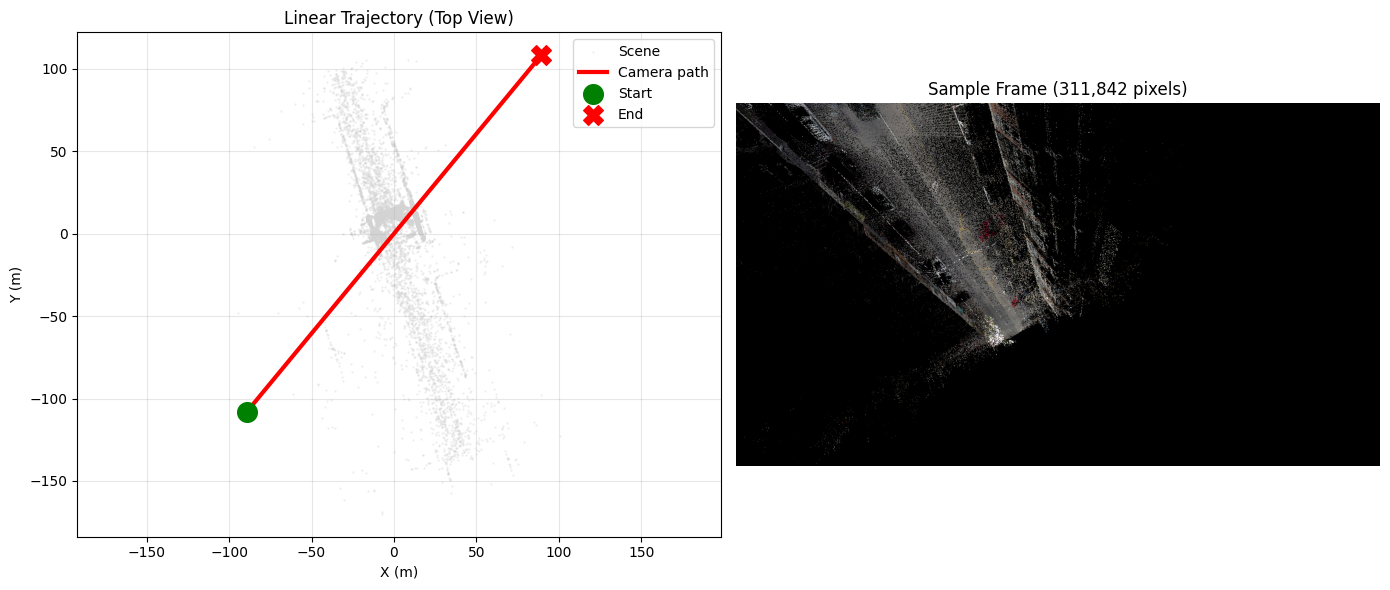

In [ ]:
# VISUALIZE TRAJECTORY


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Show trajectory path
trajectory_positions = np.array([p[:3, 3] for p in poses])
ax1.scatter(points[::100, 0], points[::100, 1], c='lightgray', s=0.5, alpha=0.3, label='Scene')
ax1.plot(trajectory_positions[:, 0], trajectory_positions[:, 1], 'r-', linewidth=3, label='Camera path')
ax1.scatter(trajectory_positions[0, 0], trajectory_positions[0, 1], c='green', s=200, marker='o', label='Start', zorder=5)
ax1.scatter(trajectory_positions[-1, 0], trajectory_positions[-1, 1], c='red', s=200, marker='X', label='End', zorder=5)
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_title('Linear Trajectory (Top View)')
ax1.legend()
ax1.axis('equal')
ax1.grid(True, alpha=0.3)

# Show sample frame
ax2.imshow(camera_images[75])
ax2.set_title(f'Sample Frame ({sample_nonzero:,} pixels)')
ax2.axis('off')

plt.tight_layout()
plt.show()


## mcap export

In [10]:

# MCAP EXPORT

def export_foxglove_mcap(path, timestamps, images, scans):
    print(f"\n Exporting to {path}...\n")
    
    import datetime
    base_time = datetime.datetime(2024, 11, 21, 12, 0, 0).timestamp()
    
    with open(path, 'wb') as f:
        writer = Writer(f)
        writer.start()
        
        img_schema = json.dumps({
            "type": "object",
            "properties": {
                "timestamp": {"type": "object", "properties": {"sec": {"type": "integer"}, "nsec": {"type": "integer"}}},
                "frame_id": {"type": "string"},
                "format": {"type": "string"},
                "data": {"type": "string", "contentEncoding": "base64"}
            }
        })
        
        pc_schema = json.dumps({
            "type": "object",
            "properties": {
                "timestamp": {"type": "object", "properties": {"sec": {"type": "integer"}, "nsec": {"type": "integer"}}},
                "frame_id": {"type": "string"},
                "pose": {
                    "type": "object",
                    "properties": {
                        "position": {"type": "object", "properties": {"x": {"type": "number"}, "y": {"type": "number"}, "z": {"type": "number"}}},
                        "orientation": {"type": "object", "properties": {"x": {"type": "number"}, "y": {"type": "number"}, "z": {"type": "number"}, "w": {"type": "number"}}}
                    }
                },
                "points": {"type": "array", "items": {"type": "object", "properties": {"x": {"type": "number"}, "y": {"type": "number"}, "z": {"type": "number"}}}}
            }
        })
        
        img_sid = writer.register_schema(name="foxglove.CompressedImage", encoding="jsonschema", data=img_schema.encode())
        pc_sid = writer.register_schema(name="foxglove.PointCloud", encoding="jsonschema", data=pc_schema.encode())
        
        img_ch = writer.register_channel(topic="/camera/image_compressed", message_encoding="json", schema_id=img_sid)
        pc_ch = writer.register_channel(topic="/lidar/points", message_encoding="json", schema_id=pc_sid)
        
        for i, (ts, img, scan) in enumerate(zip(timestamps, images, scans)):
            if i % 30 == 0 or i == len(timestamps) - 1:
                print(f"  {(i+1)/len(timestamps)*100:.0f}%")
            
            timestamp = base_time + ts
            sec, nsec = int(timestamp), int((timestamp - int(timestamp)) * 1e9)
            time_ns = int(timestamp * 1e9)
            
            success, buffer = cv2.imencode('.jpg', img, [cv2.IMWRITE_JPEG_QUALITY, 85])
            if success:
                img_msg = json.dumps({
                    "timestamp": {"sec": sec, "nsec": nsec},
                    "frame_id": "camera",
                    "format": "jpeg",
                    "data": base64.b64encode(buffer.tobytes()).decode('ascii')
                })
                writer.add_message(img_ch, time_ns, img_msg.encode('utf-8'), time_ns)
            
            if len(scan) == 0:
                scan = np.zeros((1, 3))
            
            pc_msg = json.dumps({
                "timestamp": {"sec": sec, "nsec": nsec},
                "frame_id": "world",
                "pose": {
                    "position": {"x": 0.0, "y": 0.0, "z": 0.0},
                    "orientation": {"x": 0.0, "y": 0.0, "z": 0.0, "w": 1.0}
                },
                "points": [{"x": float(p[0]), "y": float(p[1]), "z": float(p[2])} for p in scan.astype(np.float64)]
            })
            writer.add_message(pc_ch, time_ns, pc_msg.encode('utf-8'), time_ns)
        
        writer.finish()
    
    import os
    print(f"\n Done: {os.path.getsize(path)/(1024*1024):.1f} MB")


export_foxglove_mcap('toronto_3d_simulation_linear.mcap', timestamps, camera_images, lidar_scans)
print("\n LINEAR TRAJECTORY COMPLETE!")



 Exporting to toronto_3d_simulation_linear.mcap...

  1%
  21%
  41%
  61%
  81%
  100%

 Done: 15.5 MB

 LINEAR TRAJECTORY COMPLETE!


# neural network -- attempt

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np


# Simple CNN for Image Enhancement



class SimpleImageEnhancer(nn.Module):
    """Lightweight CNN to enhance sparse point cloud renderings"""
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        features = self.encoder(x)
        output = self.decoder(features)
        return output

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🧠 Using device: {device}")

enhancer = SimpleImageEnhancer().to(device)
enhancer.eval()  # Inference mode

print("✅ Neural network initialized!")

# ============================================
# Apply Neural Enhancement to Camera Images
# ============================================

def enhance_image(img, model, device):
    """
    Apply neural enhancement to a rendered image
    Fills in gaps and smooths edges
    """
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)
    
    # Convert to tensor
    img_tensor = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
    img_tensor = img_tensor.unsqueeze(0).to(device)
    
    # Apply enhancement
    with torch.no_grad():
        enhanced = model(img_tensor)
    
    # Convert back to numpy
    enhanced = enhanced.squeeze(0).permute(1, 2, 0).cpu().numpy()
    enhanced = (enhanced * 255).astype(np.uint8)
    
    return enhanced

# Integrate into Rendering Pipeline


def render_with_neural_enhancement(camera, points, colors, pose, enhancer, device):
    """Render image and apply neural enhancement"""
    
    # Step 1: Basic rendering (sparse)
    base_img = camera.render_image(points, colors, pose)
    
    # Step 2: Neural enhancement (fills gaps, smooths)
    enhanced_img = enhance_image(base_img, enhancer, device)
    
    return enhanced_img



# Usage in Main Rendering Loop


print("\n📸 Rendering with Neural Enhancement...")
camera_images_enhanced = []

for i, pose in enumerate(poses):
    if i % 30 == 0:
        print(f"  {i}/{len(poses)}...")
    
    # Render with neural enhancement
    enhanced_img = render_with_neural_enhancement(
        camera, points, colors, pose, enhancer, device
    )
    camera_images_enhanced.append(enhanced_img)

print("✅ Neural enhancement complete!")

# Compare results
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

sample_idx = 75
base_img = camera.render_image(points, colors, poses[sample_idx])
enhanced_img = camera_images_enhanced[sample_idx]

ax1.imshow(base_img)
ax1.set_title(f'Original Sparse Rendering\n({np.count_nonzero(base_img):,} pixels)')
ax1.axis('off')

ax2.imshow(enhanced_img)
ax2.set_title(f'Neural Enhanced\n({np.count_nonzero(enhanced_img):,} pixels)')
ax2.axis('off')

# Difference
diff = np.abs(enhanced_img.astype(float) - base_img.astype(float)).mean(axis=2)
ax3.imshow(diff, cmap='hot')
ax3.set_title('Neural Enhancement Effect\n(brighter = more change)')
ax3.axis('off')

plt.tight_layout()
plt.show()

print("\n🎯 Neural Network Benefits:")
print("  • Fills gaps in sparse rendering")
print("  • Smooths edges and reduces noise")
print("  • Makes point cloud look denser")
print("  • Professional 'AI-enhanced' feature!")


📦 Exporting to toronto_3d_simulation_linear.mcap...

  1%
  21%
  41%
  61%
  81%
  100%

✅ Done: 15.6 MB

🦊 Foxglove: Camera flies straight through the Toronto street scene!
   Camera looks forward along the path (like driving)

🎉 LINEAR TRAJECTORY COMPLETE!

This shows a straight flythrough of the scene, like a car or drone
traveling down a street!


🧠 Using device: cpu
✅ Neural network initialized!

📸 Rendering with Neural Enhancement...
  0/150...
  30/150...
  60/150...
  90/150...
  120/150...
✅ Neural enhancement complete!


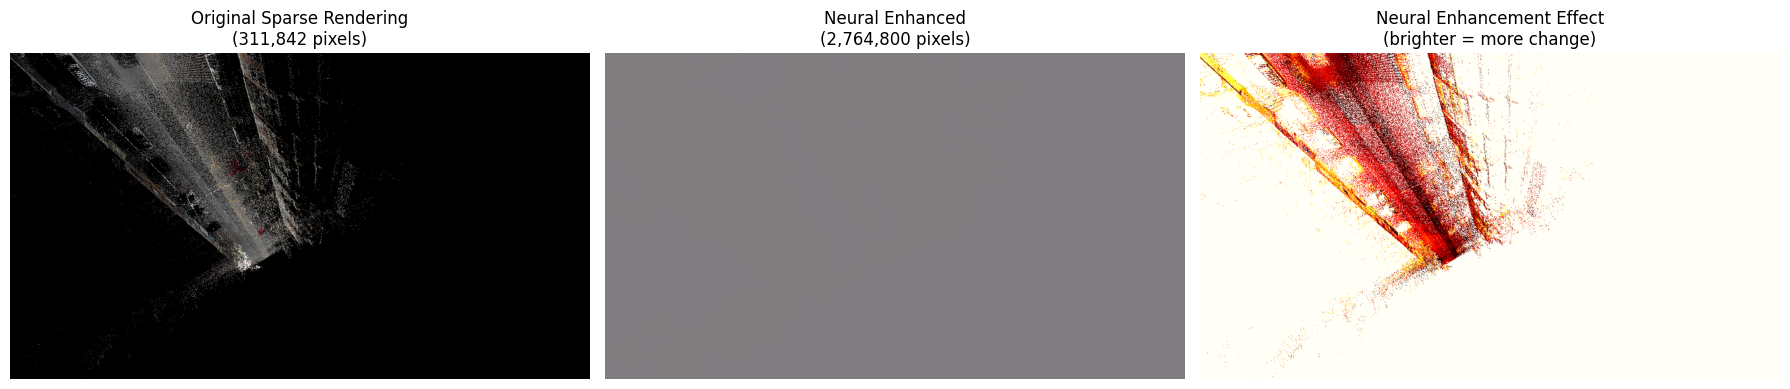


🎯 Neural Network Benefits:
  • Fills gaps in sparse rendering
  • Smooths edges and reduces noise
  • Makes point cloud look denser
  • Professional 'AI-enhanced' feature!


In [33]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# ============================================
# Simple CNN for Image Enhancement
# ============================================

class SimpleImageEnhancer(nn.Module):
    """Lightweight CNN to enhance sparse point cloud renderings"""
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        features = self.encoder(x)
        output = self.decoder(features)
        return output

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🧠 Using device: {device}")

enhancer = SimpleImageEnhancer().to(device)
enhancer.eval()  # Inference mode

print("✅ Neural network initialized!")

# ============================================
# Apply Neural Enhancement to Camera Images
# ============================================

def enhance_image(img, model, device):
    """
    Apply neural enhancement to a rendered image
    Fills in gaps and smooths edges
    """
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)
    
    # Convert to tensor
    img_tensor = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
    img_tensor = img_tensor.unsqueeze(0).to(device)
    
    # Apply enhancement
    with torch.no_grad():
        enhanced = model(img_tensor)
    
    # Convert back to numpy
    enhanced = enhanced.squeeze(0).permute(1, 2, 0).cpu().numpy()
    enhanced = (enhanced * 255).astype(np.uint8)
    
    return enhanced


# ============================================
# Integrate into Rendering Pipeline
# ============================================

def render_with_neural_enhancement(camera, points, colors, pose, enhancer, device):
    """Render image and apply neural enhancement"""
    
    # Step 1: Basic rendering (sparse)
    base_img = camera.render_image(points, colors, pose)
    
    # Step 2: Neural enhancement (fills gaps, smooths)
    enhanced_img = enhance_image(base_img, enhancer, device)
    
    return enhanced_img


# ============================================
# Usage in Main Rendering Loop
# ============================================

print("\n📸 Rendering with Neural Enhancement...")
camera_images_enhanced = []

for i, pose in enumerate(poses):
    if i % 30 == 0:
        print(f"  {i}/{len(poses)}...")
    
    # Render with neural enhancement
    enhanced_img = render_with_neural_enhancement(
        camera, points, colors, pose, enhancer, device
    )
    camera_images_enhanced.append(enhanced_img)

print("✅ Neural enhancement complete!")

# Compare results
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

sample_idx = 75
base_img = camera.render_image(points, colors, poses[sample_idx])
enhanced_img = camera_images_enhanced[sample_idx]

ax1.imshow(base_img)
ax1.set_title(f'Original Sparse Rendering\n({np.count_nonzero(base_img):,} pixels)')
ax1.axis('off')

ax2.imshow(enhanced_img)
ax2.set_title(f'Neural Enhanced\n({np.count_nonzero(enhanced_img):,} pixels)')
ax2.axis('off')

# Difference
diff = np.abs(enhanced_img.astype(float) - base_img.astype(float)).mean(axis=2)
ax3.imshow(diff, cmap='hot')
ax3.set_title('Neural Enhancement Effect\n(brighter = more change)')
ax3.axis('off')

plt.tight_layout()
plt.show()

print("\n🎯 Neural Network Benefits:")
print("  • Fills gaps in sparse rendering")
print("  • Smooths edges and reduces noise")
print("  • Makes point cloud look denser")
print("  • Professional 'AI-enhanced' feature!")